In [1]:
import numpy as np
from utils import load_surf, load_config, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.signal import clean
import nibabel as nib
import os

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']

subject = 'sub-004'
STORIES = cfg['STORIES']

tr = 1.5

from nilearn import plotting, datasets

envelope_all = []
surf_data_all = []
n_trs_all = []
for istory, story in enumerate(STORIES):
    # auditory envelope
    audio, sr = load_mp3(STIMDIR, story)
    audio_envelope = get_envelope(audio)
    story_length = len(audio) / sr # in seconds

    # average envelope every 0.1 seconds
    window = 0.1
    audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

    zEnv = zscore(lanczosinterp2D(audio_envelope_avg, np.arange(audio_envelope_avg.shape[0]) * window, np.arange(13.5 // tr, story_length // tr) * tr), axis=0)

    envelope_all.append(zEnv)

    n_trs = zEnv.shape[0]
    n_trs_all.append(n_trs)
    
    surf_data = load_surf(DATADIR, subject, story)
    tr_len = 1.5
    surf_data = zscore(butterworth_highpass(surf_data, tr_len, 0.01), axis=1)

    surf_data = surf_data[:, 17:n_trs+17] # trim the first (8 + 9) TRs of wait period + music
    surf_data_all.append(surf_data)



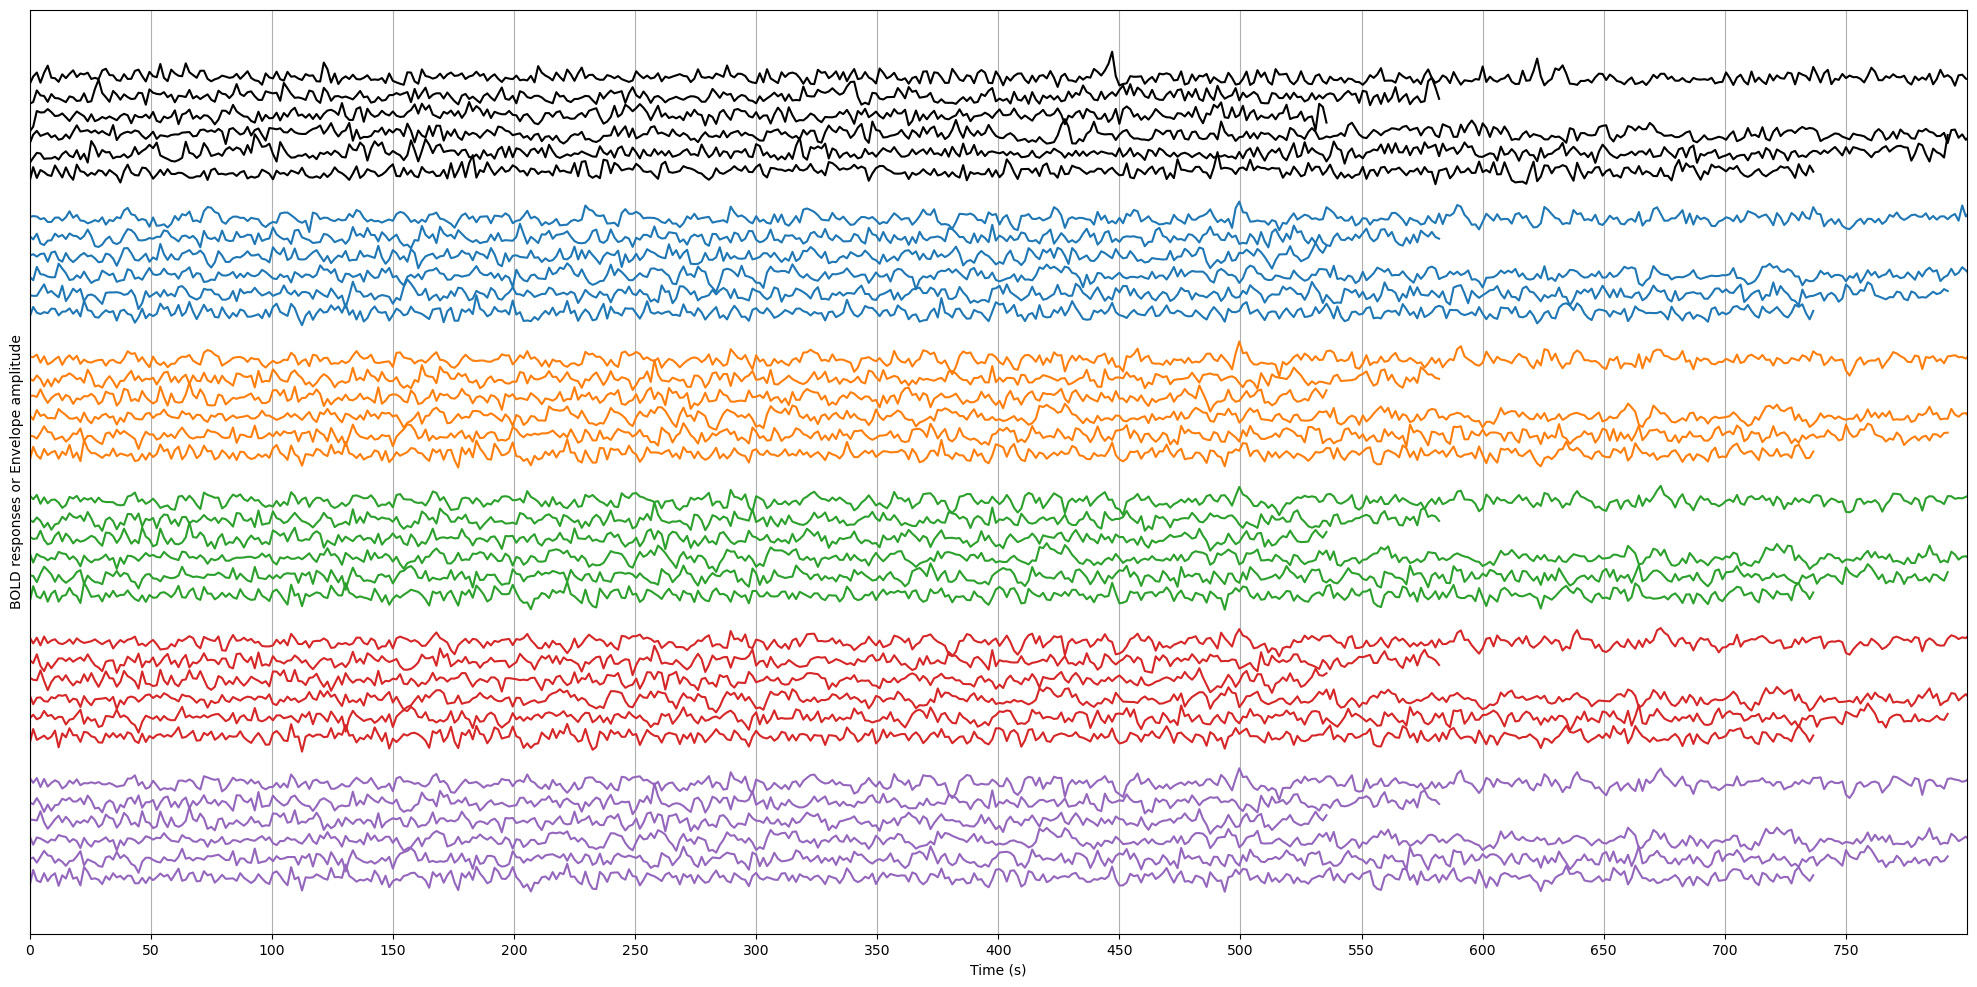

In [4]:
from matplotlib.pyplot import figure
selvoxels = [1663, 16953, 11411, 3732, 25149]

colors = plt.cm.tab10.colors
f = figure(figsize=(25,12))
f.clf()
ax = f.add_subplot(1,1,1)
for istory in range(len(STORIES)):
    ax.plot(np.arange(n_trs_all[istory]) * tr, envelope_all[istory].flatten() + 30 - 4 * istory, label="Envelope", color='k')
    for i, voxel in enumerate(selvoxels):
        ax.plot(np.arange(n_trs_all[istory]) * tr, surf_data_all[istory][voxel, :].flatten() - 30 * i - 4 * istory, label=f"Voxel {voxel}", color=colors[i])




ax.set_xlim(0, 800)
ax.set_xticks(range(0, 800, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()